C:\Users\ridva\AppData\Local\Temp\ipykernel_12528\369368289.py:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


Epoch 1/50
13/13 - 3s - loss: 0.7493 - val_loss: 0.7602 - 3s/epoch - 268ms/step
Epoch 2/50
13/13 - 0s - loss: 0.5882 - val_loss: 0.3637 - 54ms/epoch - 4ms/step
Epoch 3/50
13/13 - 0s - loss: 0.5414 - val_loss: 0.3629 - 51ms/epoch - 4ms/step
Epoch 4/50
13/13 - 0s - loss: 0.5110 - val_loss: 0.3419 - 56ms/epoch - 4ms/step
Epoch 5/50
13/13 - 0s - loss: 0.5039 - val_loss: 0.3366 - 52ms/epoch - 4ms/step
Epoch 6/50
13/13 - 0s - loss: 0.4705 - val_loss: 0.3334 - 48ms/epoch - 4ms/step
Epoch 7/50
13/13 - 0s - loss: 0.4762 - val_loss: 0.3469 - 54ms/epoch - 4ms/step
Epoch 8/50
13/13 - 0s - loss: 0.4558 - val_loss: 0.3501 - 57ms/epoch - 4ms/step
Epoch 9/50
13/13 - 0s - loss: 0.4450 - val_loss: 0.3454 - 53ms/epoch - 4ms/step
Epoch 10/50
13/13 - 0s - loss: 0.4331 - val_loss: 0.3625 - 53ms/epoch - 4ms/step
Epoch 11/50
13/13 - 0s - loss: 0.4475 - val_loss: 0.3558 - 56ms/epoch - 4ms/step
4/4 [==============================] - 1s 1ms/step
Test RMSE: 10.242961971001618


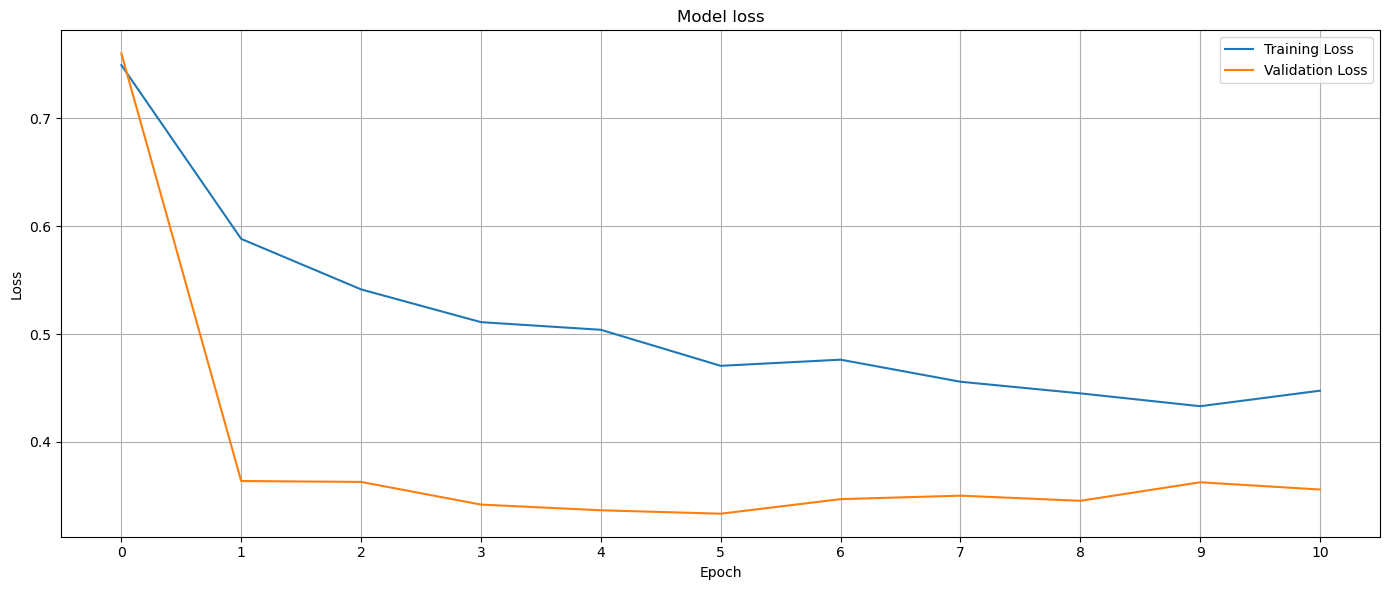

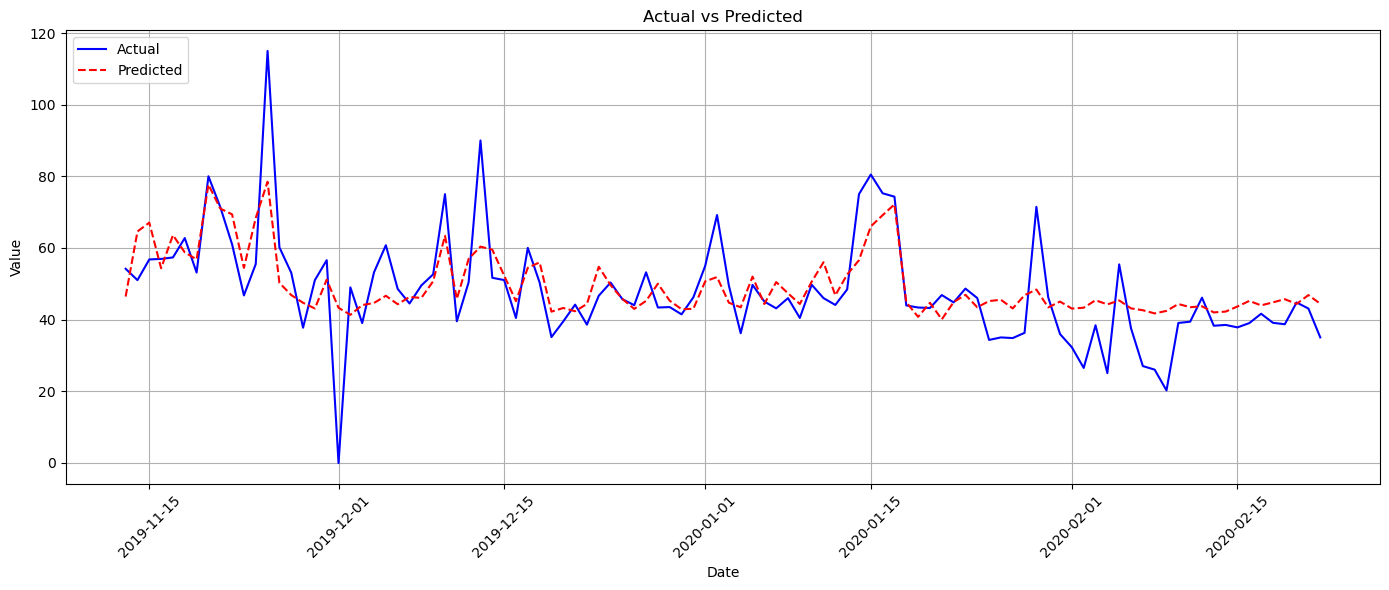

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('reshaped_dataset_corrected-2018-2020.csv')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Save dates before introducing lag features
dates = df['Date'].tolist()

# Drop the 'Date' column after saving
df.drop(columns='Date', inplace=True)

# Generate lag features for both the target variable and the wind offshore power prediction
for i in range(1, 8):
    df[f'Price_Lag_{i}'] = df['Day-ahead Price [EUR/MWh]'].shift(i)
    df[f'Wind_Lag_{i}'] = df['Wind Offshore  [MW] Day Ahead'].shift(i)

# Drop NaN rows introduced by the lag features
df.dropna(inplace=True)

# Splitting the dataset
n_train_hours = int(len(df) * 0.8)
train, test = df.iloc[:n_train_hours, :], df.iloc[n_train_hours:, :]

# Extract test dates
test_dates = dates[n_train_hours:n_train_hours + len(test)]  # Adjusted to match test set length

# Sorting the index
train.sort_index(inplace=True)
test.sort_index(inplace=True)

# Separating the target variable
train_X, train_y = train.drop(columns=['Day-ahead Price [EUR/MWh]']), train['Day-ahead Price [EUR/MWh]']
test_X, test_y = test.drop(columns=['Day-ahead Price [EUR/MWh]']), test['Day-ahead Price [EUR/MWh]']

# Scaling the dataset
scaler_X = StandardScaler().fit(train_X)
train_X_scaled = scaler_X.transform(train_X)
test_X_scaled = scaler_X.transform(test_X)

scaler_y = StandardScaler().fit(train_y.values.reshape(-1, 1))
train_y_scaled = scaler_y.transform(train_y.values.reshape(-1, 1))
test_y_scaled = scaler_y.transform(test_y.values.reshape(-1, 1))

# Reshaping for LSTM
train_X_reshaped = train_X_scaled.reshape((train_X_scaled.shape[0], 1, train_X_scaled.shape[1]))
test_X_reshaped = test_X_scaled.reshape((test_X_scaled.shape[0], 1, test_X_scaled.shape[1]))

# Adjusted LSTM model architecture
model = Sequential()
model.add(LSTM(60, input_shape=(train_X_reshaped.shape[1], train_X_reshaped.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(30, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

# Adjusting the optimizer's learning rate
optimizer = Adam(learning_rate=0.005)
model.compile(loss='mae', optimizer=optimizer)

# Adjusted batch size
batch_size = 32
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Training the model
history = model.fit(train_X_reshaped, train_y_scaled, epochs=50, batch_size=batch_size, 
                    validation_data=(test_X_reshaped, test_y_scaled), verbose=2, 
                    shuffle=False, callbacks=[early_stop])

# Prediction
yhat_scaled = model.predict(test_X_reshaped)

# Inverse scaling for forecast
inv_yhat = scaler_y.inverse_transform(yhat_scaled)

# Inverse scaling for actuals
inv_y = scaler_y.inverse_transform(test_y_scaled)

# RMSE calculation
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE:', rmse)

# Plotting the loss during training
plt.figure(figsize=(14, 6))
epochs = range(len(history.history['loss']))
plt.xticks(epochs)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Generating date range for the test dataset
date_range = pd.date_range(start=test_dates[0], end=test_dates[-1])


# Plotting the actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(date_range, inv_y, label='Actual', color='blue')
plt.plot(date_range, inv_yhat, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted')
plt.ylabel('Value')
plt.xlabel('Date')
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
